In [78]:
from ripser import Rips
import numpy as np
import matplotlib.pyplot as plt
from utils import read_xyz_file
from persim import PersistenceImager
from persim.landscapes import PersistenceLandscaper
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


In [79]:
temp = read_xyz_file("/workspaces/PersistenceComparison/xyz_data/babel/1.xyz")
rc = RipsComplex(temp[["x", 'y', 'z']].values)
rc.diag


[array([[0.        , 1.08383811],
        [0.        , 1.08413517],
        [0.        , 1.08601999],
        [0.        , 1.08613777],
        [0.        , 1.08624721],
        [0.        , 1.35073745],
        [0.        , 1.35105014],
        [0.        , 1.38580394],
        [0.        , 1.38584685],
        [0.        , 1.3907901 ],
        [0.        ,        inf]]),
 array([[1.39112115, 2.38308406]]),
 array([[2.41417909, 2.72745872]])]

In [134]:
class PersistentImage:
  def __init__(self, rips_complex, pixel_size:int = 0.1, image_size: tuple[int, int] = (20, 20)):
    self._pixel_size = pixel_size
    self._diags = rips_complex.diag
    self._hm_classes = len(self._diags)
    self.nx, self.ny = image_size
    self._xs = np.arange(0, self.nx)
    self._ys = np.arange(0, self.ny)
    self.images = self._get_images()

  def _get_images(self):
    images = {}
    for hm in range(self._hm_classes):
      hm_data = self._diags[hm]

      # convert to persistence lifetime
      hm_data[:, 1] -= hm_data[:, 0]

      # sum the smoothing kernel times weighting function
      pers_surface = []
      num_rows = hm_data.shape[0]
      for i in range(num_rows):
        b, p = hm_data[i, 0], hm_data[i,1]
        temp = np.zeros((self.nx, self.ny))
        for x in self._xs:
          for y in self._ys:
            temp[x,y] = self._gaussian_kernel(x,y, b, p) * self._weighting(b, p)
        pers_surface.append(temp)
      pers_surface = np.sum(np.array(pers_surface), axis = 0)

      # add integration
      
      images[hm] = pers_surface
    return images
  
  def _gaussian_kernel(self, x, y, b, p, sigma: float = 1):
    return (1/(2 * np.pi * sigma ** 2)) * np.exp(-1 * ((x - b)**2 + (y-p)**2)/(2*sigma**2))
  
  def _weighting(self, b, p):
    if p <= 0:
      return 0
    elif 0 < p < b:
      return p/b 
    else:
      return 1

  def featurize(self):
    return {hm: self.images[hm].flatten() for hm in range(self._hm_classes)}
    
  def plot(self, hm_class:int = 0):
    hm_images = self.images[hm_class]
    print(hm_images)
    num_images = len(hm_images)
    fig, axs = plt.subplots(1, num_images, figsize = (12, 8))
    for i in range(num_images):
      self.pimgr.plot_image(hm_images[i], axs[i])

    plt.show()

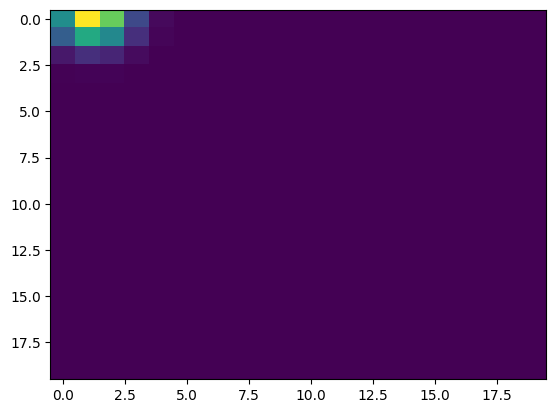

In [141]:
temp = PersistentImage(rc)
plt.imshow(temp.images[0], aspect='auto')
plt.show()